In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'differential_apa_c2c12',
        root = '..',
    )

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from lapa.result import LapaResult
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

tqdm.pandas()

In [3]:
result = LapaResult(snakemake.input['long_read'])
samples = result.samples

In [13]:
samples

['PB154', 'PB155', 'PB213', 'PB214']

In [4]:
df = pd.concat([
    result.read_apa(i)
    .set_index(['Chromosome', 'Start', 'End', 'Strand', 'gene_id'])
    [['tpm', 'count', 'gene_count', 'usage']]
    .rename(columns={'tpm': f'tpm_{i}', 'count': f'count_{i}', 
                     'gene_count': f'gene_count_{i}', 'usage': f'usage_{i}'})
    for i in samples
], axis=1).fillna(0)

In [5]:
def fisher_test_polyA(row):    
    a = row['count_PB154'] + row['count_PB155']
    b = row['count_PB213'] + row['count_PB214']
    c = row['gene_count_PB154'] + row['gene_count_PB155']
    d = row['gene_count_PB213'] + row['gene_count_PB214']

    return fisher_exact([
        [    a,     b],
        [c - a, d - b]
    ])[1]

In [6]:
df['pval'] = df.progress_apply(fisher_test_polyA, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35471/35471 [10:36<00:00, 55.69it/s]


In [7]:
df['pval_adj'] = multipletests(df['pval'], method='holm')[1]

In [8]:
df = df.reset_index()

In [9]:
site_undif = df['count_PB154'] + df['count_PB155']
site_dif = df['count_PB213'] + df['count_PB214']

gene_undif = df['gene_count_PB154'] + df['gene_count_PB155']
gene_dif = df['gene_count_PB213'] + df['gene_count_PB214']

df['usage_undif'] = site_undif / gene_undif
df['usage_dif'] = site_dif / gene_dif

df['delta_usage'] = df['usage_dif'] - df['usage_undif'] 

df_sig_apa = df[
    (df['pval_adj'] < 0.05) 
    & (df['delta_usage'].abs() > 0.3)
]

In [10]:
df_gene_mapping = pd.read_csv('data/results/common/mouse_gene_id_name_mapping.csv')
df_gene = df_sig_apa.set_index('gene_id').join(df_gene_mapping.set_index('gene_id')).reset_index()

In [11]:
df_sig_apa

,Chromosome,Start,End,Strand,gene_id,tpm_PB154,count_PB154,gene_count_PB154,usage_PB154,tpm_PB155,...,usage_PB213,tpm_PB214,count_PB214,gene_count_PB214,usage_PB214,pval,pval_adj,usage_undif,usage_dif,delta_usage
43,chr1,9745969,9745976,-,ENSMUSG00000045210.8,8.89,22.0,58.0,0.379310,8.15,...,0.090000,4.32,8.0,110.0,0.072727,1.181099e-11,4.035460e-07,0.420000,0.080952,-0.339048
91,chr1,16228803,16228809,-,ENSMUSG00000025920.19,1.62,4.0,29.0,0.137931,3.67,...,0.489362,27.55,51.0,72.0,0.708333,4.330216e-08,1.452268e-03,0.203125,0.621849,0.418724
108,chr1,16641725,16641737,-,ENSMUSG00000079658.9,27.89,69.0,94.0,0.734043,29.33,...,0.204420,21.07,39.0,184.0,0.211957,7.335789e-28,2.569287e-23,0.668246,0.208219,-0.460027
112,chr1,16643244,16643290,-,ENSMUSG00000079658.9,4.85,12.0,94.0,0.127660,5.70,...,0.552486,51.86,96.0,184.0,0.521739,1.047091e-24,3.659061e-20,0.123223,0.536986,0.413764
164,chr1,30803103,30803107,-,ENSMUSG00000048874.15,1.21,3.0,37.0,0.081081,0.41,...,0.344828,5.94,11.0,20.0,0.550000,3.491997e-07,1.161857e-02,0.051948,0.428571,0.376623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35189,chrX,134588043,134588066,+,ENSMUSG00000079435.9,20.21,50.0,114.0,0.438596,24.85,...,0.814499,151.79,281.0,351.0,0.800570,9.182731e-33,3.224516e-28,0.414179,0.808537,0.394357
35245,chrX,139672300,139672315,+,ENSMUSG00000031438.11,63.86,158.0,189.0,0.835979,55.00,...,0.390476,56.18,104.0,224.0,0.464286,2.472437e-33,8.684929e-29,0.839542,0.428571,-0.410970
35246,chrX,139673103,139673144,+,ENSMUSG00000031438.11,12.53,31.0,189.0,0.164021,8.96,...,0.600000,62.66,116.0,224.0,0.517857,5.851522e-33,2.055054e-28,0.151862,0.557604,0.405741
35369,chrX,159385664,159385727,+,ENSMUSG00000067194.6,16.17,40.0,309.0,0.129450,24.85,...,0.492701,75.09,139.0,283.0,0.491166,7.105087e-33,2.495164e-28,0.166942,0.491921,0.324979


In [12]:
df_sig_apa.to_csv(snakemake.output['sig_csv'], index=False)

In [49]:
df_sig = df_sig_apa.loc[df_sig_apa.groupby('gene_id')['pval_adj'].idxmin()]

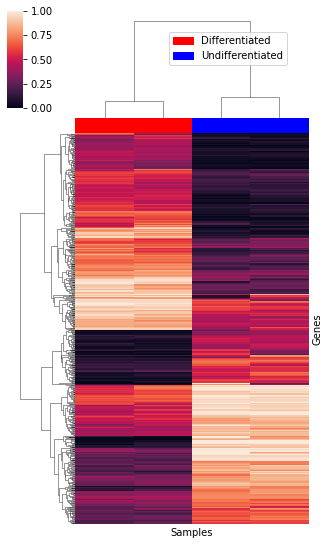

In [14]:
import seaborn as sns
import matplotlib.patches as mpatches

fig = sns.clustermap(df_sig[[f'usage_{i}' for i in samples]], figsize=(3, 5), 
               col_colors=['b', 'b', 'r', 'r'], xticklabels=False, yticklabels=False)

fig.ax_heatmap.set_xlabel('Samples')
fig.ax_heatmap.set_ylabel('Genes')

plt.legend(handles=[    
    mpatches.Patch(color='r', label='Differentiated'),
    mpatches.Patch(color='b', label='Undifferentiated')
], bbox_to_anchor=(0.9, 0.95), bbox_transform=plt.gcf().transFigure, loc='upper right')

fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.5)  # scale current size by 1.5
plt.savefig("out.png", dpi=400)

In [15]:
df_gene = df.loc[df.groupby('gene_id')['pval_adj'].idxmin()]

In [16]:
df_gene['-log10(p-value corrected)'] = -np.log10(df_gene['pval_adj'])

/data/homezvol2/mcelik/.conda/envs/lapa/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


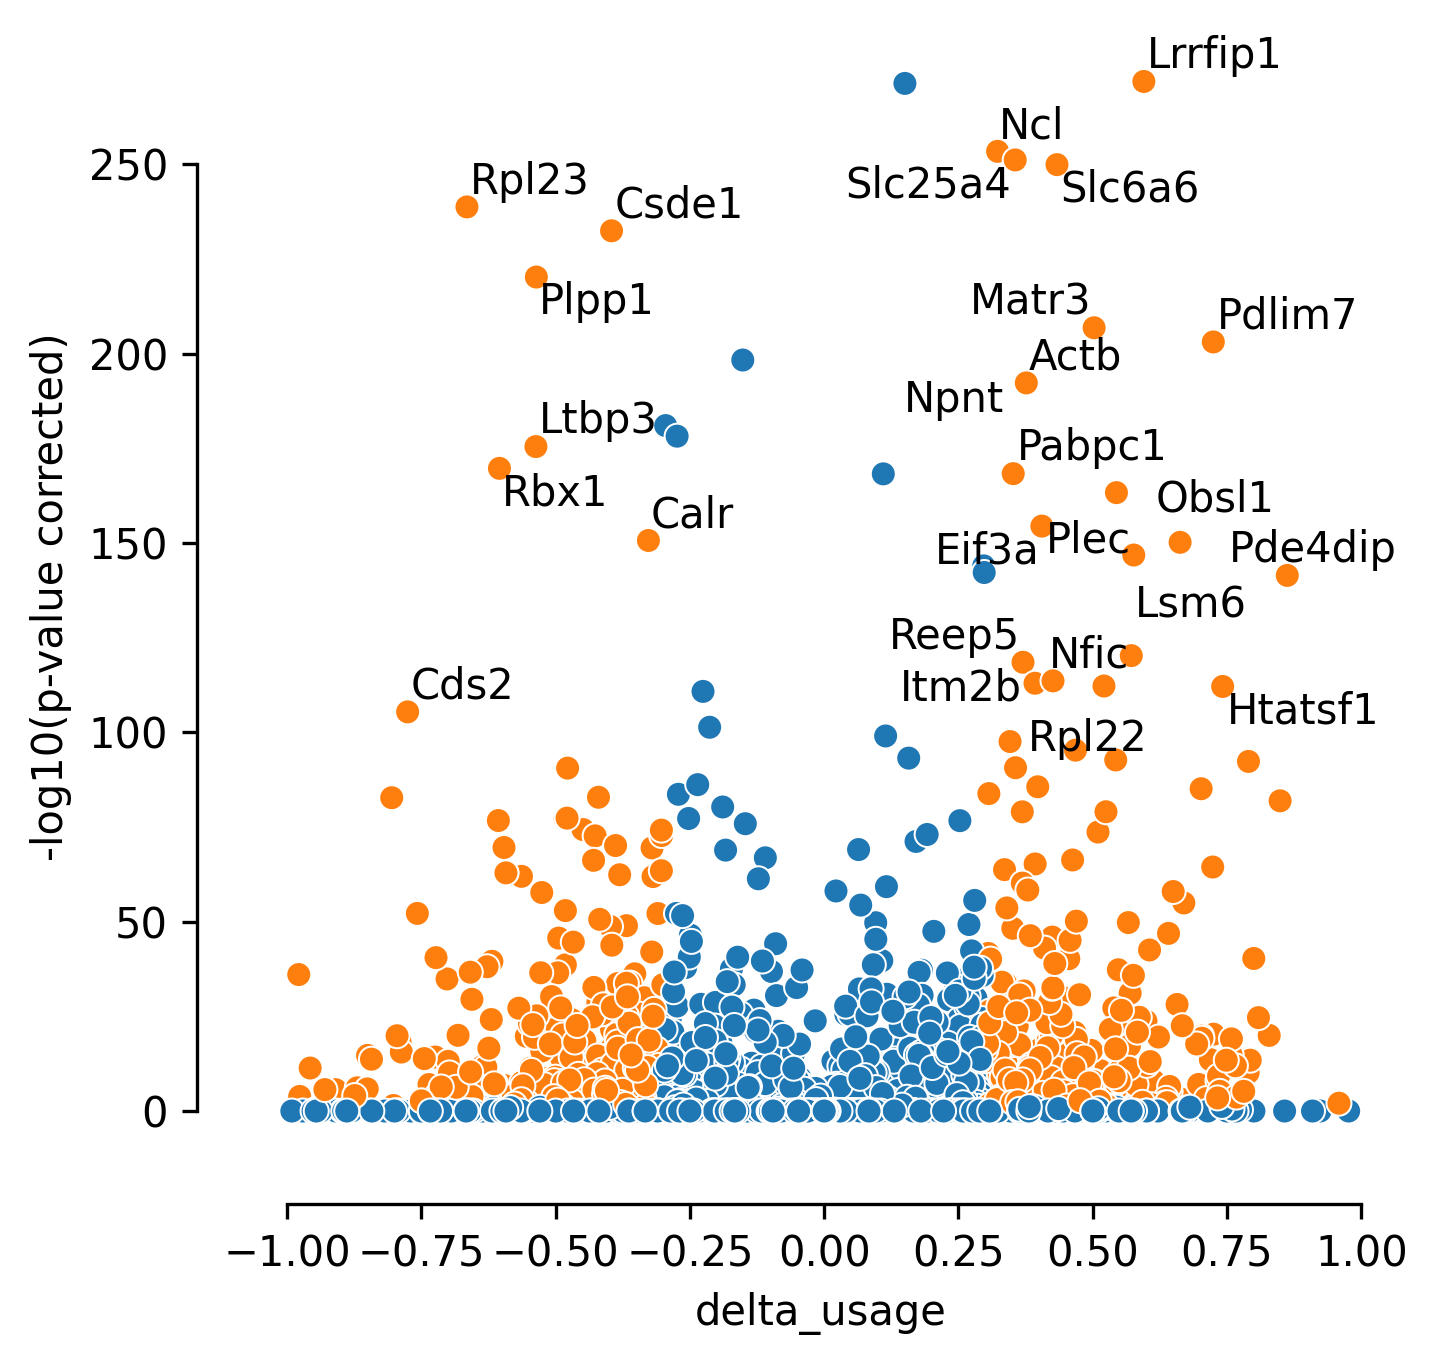

In [56]:
plt.figure(figsize=(5, 5), dpi=300)
from adjustText import adjust_text

df_gene = df_gene[np.isfinite(df_gene['-log10(p-value corrected)'])]
df_gene['sig'] = (df_gene['delta_usage'].abs() > 0.3) & (df_gene['pval_adj'] < 0.05)

ax = sns.scatterplot(data=df_gene, x='delta_usage', y='-log10(p-value corrected)', hue='sig')

_df = df_gene[(df_gene['delta_usage'].abs() > 0.3) & (df_gene['-log10(p-value corrected)'] > 100)]

text = [
    plt.text(row['delta_usage'], row['-log10(p-value corrected)'], row['gene_name'])
    for _, row in _df.iterrows()
]
adjust_text(text)
sns.despine(offset=10, trim=True)
plt.legend([],[], frameon=False)